In [1]:
from itertools import product
import pprint

#%matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy import interpolate

import iqsq
from iqsq import (
    iq_cpu_naive,
    iq_cpu_opt_1,
    iq_gpu_naive,
    iq_gpu_opt_1,
    iq_gpu_opt_2,
    q_constants
)

# could combine these files from the start?
# Constants
df1 = iqsq.read_aff_elements('GrSqf_cal_AP_Oct27/aff_elementonly.txt', header=None)
df2 = iqsq.read_aff_parameters('GrSqf_cal_AP_Oct27/aff_parmonly.txt', header=None, delim_whitespace=True)
#sf_df = df2.T
#sf_df.columns = df1[0]
sf_df = df2
sf_df.index = df1[0]
sf_df

,0,1,2,3,4,5,6,7,8
0,,,,,,,,,
H,0.489918,20.659300,0.262003,7.74039,0.196767,49.5519,0.049879,2.20159,0.001305
H1-,0.897661,53.136800,0.565616,15.18700,0.415815,186.5760,0.116973,3.56709,0.002389
He,0.873400,9.103700,0.630900,3.35680,0.311200,22.9276,0.178000,0.98210,0.006400
Li,1.128200,3.954600,0.750800,1.05240,0.617500,85.3905,0.465300,168.26100,0.037700
Li1+,0.696800,4.623700,0.788800,1.95570,0.341400,0.6316,0.156300,10.09530,0.016700
...,...,...,...,...,...,...,...,...,...
Pu6+,35.173600,0.473204,22.718100,2.73848,14.763500,11.5530,2.286780,20.93030,13.058200
Am,36.670600,0.483629,24.099200,3.20647,17.341500,14.3136,3.493310,102.27300,13.359200
Cm,36.648800,0.465154,24.409600,3.08997,17.399000,13.4346,4.216650,88.48340,13.288700


In [2]:
sf_df = iqsq.build_scattering_factors_table(
    aff_elements_fp='GrSqf_cal_AP_Oct27/aff_elementonly.txt',
    aff_parameters_fp='GrSqf_cal_AP_Oct27/aff_parmonly.txt'
)
sf_df

,0,1,2,3,4,5,6,7,8
0,,,,,,,,,
H,0.489918,20.659300,0.262003,7.74039,0.196767,49.5519,0.049879,2.20159,0.001305
H1-,0.897661,53.136800,0.565616,15.18700,0.415815,186.5760,0.116973,3.56709,0.002389
He,0.873400,9.103700,0.630900,3.35680,0.311200,22.9276,0.178000,0.98210,0.006400
Li,1.128200,3.954600,0.750800,1.05240,0.617500,85.3905,0.465300,168.26100,0.037700
Li1+,0.696800,4.623700,0.788800,1.95570,0.341400,0.6316,0.156300,10.09530,0.016700
...,...,...,...,...,...,...,...,...,...
Pu6+,35.173600,0.473204,22.718100,2.73848,14.763500,11.5530,2.286780,20.93030,13.058200
Am,36.670600,0.483629,24.099200,3.20647,17.341500,14.3136,3.493310,102.27300,13.359200
Cm,36.648800,0.465154,24.409600,3.08997,17.399000,13.4346,4.216650,88.48340,13.288700


In [3]:
# just a test
from io import StringIO
test_xyz = StringIO(
"""\
H   0 0 1
H1- 0 1 0
He  1 0 0
H   0 0 2
H1- 0 2 0
He  2 0 0
""")
#test_atom_positions_df = load_atom_positions(filename=test_xyz)
# the row-column orientation of the atom position dataframe has changed
test_atom_positions_df = iqsq.read_atom_positions(atom_positions_path=test_xyz)
test_atom_positions_df

,x,y,z
H,0,0,1
H1-,0,1,0
He,1,0,0
H,0,0,2
H1-,0,2,0
He,2,0,0


In [4]:
# just a test
test_atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df=test_atom_positions_df)
print(test_atom_distance_matrix_df)

            H       H1-        He         H       H1-        He
H    0.000000  1.414214  1.414214  1.000000  2.236068  2.236068
H1-  1.414214  0.000000  1.414214  2.236068  1.000000  2.236068
He   1.414214  1.414214  0.000000  2.236068  2.236068  1.000000
H    1.000000  2.236068  2.236068  0.000000  2.828427  2.828427
H1-  2.236068  1.000000  2.236068  2.828427  0.000000  2.828427
He   2.236068  2.236068  1.000000  2.828427  2.828427  0.000000


In [5]:
# just a test
qs = np.arange(0.0, 1.0, 0.2)

print("naive")
print(q_constants.naive(scattering_factors_df=sf_df, qs=qs).head())

qs_expanded = np.expand_dims(qs, axis=(1, 2))
print(f"qs_expanded.shape: {qs_expanded.shape}")
print("qs_expanded")
print(qs_expanded)

print(qs.flatten())

print("optimize_1")
q_atom_constants_df = q_constants.optimize_1(
    qs=qs,
    atom_distance_matrix_df=test_atom_distance_matrix_df,
    scattering_factors_df=sf_df,
)

print("q_constants_df")
print(q_atom_constants_df.head())

Fi_df = q_atom_constants_df.loc[test_atom_distance_matrix_df.index]
print("Fi_df")
print(Fi_df)

#q_atom_constants_matrix = q_constants_df.to_numpy()
#print(q_atom_constants_matrix)

Fi_matrix = Fi_df.to_numpy()
print("Fi_matrix")
print(Fi_matrix)

Fi = np.expand_dims(Fi_matrix.T, axis=2)
print("Fi.shape")
print(Fi.shape)

Fj = np.expand_dims(Fi_matrix.T, axis=1)
print("Fj.shape")
print(Fj.shape)

FiFj = np.matmul(Fi, Fj)
print("FiFj.shape")
print(FiFj.shape)

naive
           0.0       0.2       0.4       0.6       0.8
0                                                     
H     0.999872  0.994320  0.977930  0.951482  0.916186
H1-   1.998454  1.964981  1.870721  1.731786  1.568489
He    1.999900  1.995506  1.982416  1.960904  1.931416
Li    2.999500  2.965543  2.870076  2.730106  2.567696
Li1+  2.000000  1.998340  1.993373  1.985137  1.973698
qs_expanded.shape: (5, 1, 1)
qs_expanded
[[[0. ]]

 [[0.2]]

 [[0.4]]

 [[0.6]]

 [[0.8]]]
[0.  0.2 0.4 0.6 0.8]
optimize_1
q_constants_df
          0.0       0.2       0.4       0.6       0.8
0                                                    
H    0.999872  0.994320  0.977930  0.951482  0.916186
H1-  1.998454  1.964981  1.870721  1.731786  1.568489
He   1.999900  1.995506  1.982416  1.960904  1.931416
Fi_df
          0.0       0.2       0.4       0.6       0.8
H    0.999872  0.994320  0.977930  0.951482  0.916186
H1-  1.998454  1.964981  1.870721  1.731786  1.568489
He   1.999900  1.995506  1.98241

In [6]:
Fi_df

,0.0,0.2,0.4,0.6,0.8
H,0.999872,0.994320,0.977930,0.951482,0.916186
H1-,1.998454,1.964981,1.870721,1.731786,1.568489
He,1.999900,1.995506,1.982416,1.960904,1.931416
H,0.999872,0.994320,0.977930,0.951482,0.916186
H1-,1.998454,1.964981,1.870721,1.731786,1.568489
He,1.999900,1.995506,1.982416,1.960904,1.931416


In [7]:
# just a test
iq_cpu_opt_1.calculate_iq(
    scattering_factors_df=sf_df,
    atom_distance_matrix_df=test_atom_distance_matrix_df,
    qmin=0.5,
    qmax=0.6,
    qstep=0.05
)

atom_element
Index(['H', 'H1-', 'He', 'H', 'H1-', 'He'], dtype='object')
unique elements: {'H1-', 'H', 'He'}
reduced_scattering_factors.shape: (3, 9)
q_range.shape: (2,)
q_reduced_scattering_size: 54
q_element_constants.shape: (2, 3)
q_element_constants size: 6
Q*A*A: 72
Fi_df.shape: (6, 2)
Fi_df size: 12
Fi_matrix.shape: (6, 2)
Fi.shape: (2, 6, 1)
Fj.shape: (2, 1, 6)
FiFj.shape: (2, 6, 6)
FiFj size: 72
Iq.shape
(2, 6, 6)
Iq_sum.shape:
(2,)


/home/jlynch/project/iq-on-gpu/iqsq/iqsq/iq_cpu_opt_1.py:124: RuntimeWarning: invalid value encountered in true_divide
  sin_term_matrix = np.sin(qs_atom_distance_matrix) / qs_atom_distance_matrix


0

In [8]:
q = np.arange(0.1, 0.3, 0.1)
print(q)
print(f"q.shape: {q.shape}")

test_atom_distance_matrix = test_atom_distance_matrix_df.to_numpy()
print(test_atom_distance_matrix)

q = np.expand_dims(q, axis=(1,2))
print(f"q.shape {q.shape}")

q * test_atom_distance_matrix

[0.1 0.2]
q.shape: (2,)
[[0.         1.41421356 1.41421356 1.         2.23606798 2.23606798]
 [1.41421356 0.         1.41421356 2.23606798 1.         2.23606798]
 [1.41421356 1.41421356 0.         2.23606798 2.23606798 1.        ]
 [1.         2.23606798 2.23606798 0.         2.82842712 2.82842712]
 [2.23606798 1.         2.23606798 2.82842712 0.         2.82842712]
 [2.23606798 2.23606798 1.         2.82842712 2.82842712 0.        ]]
q.shape (2, 1, 1)


array([[[0.        , 0.14142136, 0.14142136, 0.1       , 0.2236068 ,
         0.2236068 ],
        [0.14142136, 0.        , 0.14142136, 0.2236068 , 0.1       ,
         0.2236068 ],
        [0.14142136, 0.14142136, 0.        , 0.2236068 , 0.2236068 ,
         0.1       ],
        [0.1       , 0.2236068 , 0.2236068 , 0.        , 0.28284271,
         0.28284271],
        [0.2236068 , 0.1       , 0.2236068 , 0.28284271, 0.        ,
         0.28284271],
        [0.2236068 , 0.2236068 , 0.1       , 0.28284271, 0.28284271,
         0.        ]],

       [[0.        , 0.28284271, 0.28284271, 0.2       , 0.4472136 ,
         0.4472136 ],
        [0.28284271, 0.        , 0.28284271, 0.4472136 , 0.2       ,
         0.4472136 ],
        [0.28284271, 0.28284271, 0.        , 0.4472136 , 0.4472136 ,
         0.2       ],
        [0.2       , 0.4472136 , 0.4472136 , 0.        , 0.56568542,
         0.56568542],
        [0.4472136 , 0.2       , 0.4472136 , 0.56568542, 0.        ,
         0.56568542

In [9]:
# just a test
# compare results with g_calculate_iq
iq_cpu_naive.calculate_iq(
    scattering_factors_df=sf_df,
    atom_distance_matrix_df=test_atom_distance_matrix_df,
    qmin=0.5,
    qmax=0.6,
    qstep=0.05
)

atom_element
Index(['H', 'H1-', 'He', 'H', 'H1-', 'He'], dtype='object')
unique elements: {'H1-', 'H', 'He'}
initial Fi
[[0. 0. 0. 0. 0. 0.]]
q_range: [0.5  0.55]


/home/jlynch/project/iq-on-gpu/iqsq/iqsq/iq_cpu_naive.py:76: RuntimeWarning: invalid value encountered in true_divide
  sin_term_matrix = np.sin(q * atom_distance_matrix) / (


(array([[ 0.5       , 78.19738854],
        [ 0.55      , 74.37626125]]),
 array([[0.95897759, 1.76960675, 1.96705017, 0.95897759, 1.76960675,
         1.96705017]]))

In [10]:
# just a test
# compare results with calculate_iq
# not working yet  iq_gpu_naive.calculate_iq(scattering_factors_df=sf_df, atom_distance_matrix_df=test_atom_distance_matrix_df, qmin=0.5, qmax=0.6, qstep=0.05)

In [11]:
# just a test
# compare results with calculate_iq
# not working yetiq_gpu_opt_1.calculate_iq(scattering_factors_df=sf_df, atom_distance_matrix_df=test_atom_distance_matrix_df, qmin=0.5, qmax=0.6, qstep=0.05)

In [12]:
def getQIq(scattering_factors_df, atom_positions_path, qmin=0.6, qmax=30, qstep=0.02, auto_save=False):
    atom_positions_df = iqsq.read_atom_positions(atom_positions_path=atom_positions_path)
    
    atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
    #print("atom_distance_matrix_df", atom_distance_matrix_df.shape)
    #print(atom_distance_matrix_df[:10])

    qIq, Fi = iq_cpu_naive.calculate_iq(
        scattering_factors_df=scattering_factors_df,
        atom_distance_matrix_df=atom_distance_matrix_df,
        qmin=qmin,
        qmax=qmax,
        qstep=qstep
    )
    if auto_save:
        np.savetxt(atom_positions_path.split('.')[0]+'_QIq_Restuls.txt',qIq)
    return qIq, Fi

In [13]:
%load_ext line_profiler

In [14]:
# this takes ~3s
# atom_positions_df = iqsq.read_atom_positions("GrSqf_cal_AP_Oct27/5IrC_r5a-1Ir.xyz")
# atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
# %lprun -f \
# iq_cpu_naive.calculate_iq iq_cpu_naive.calculate_iq( \
#     scattering_factors_df=sf_df, \
#     atom_distance_matrix_df=atom_distance_matrix_df, \
#     qmin=0.01, \
#     qmax=30, \
#     qstep=0.01 \
# )

In [15]:
# this takes ~0.06s
# atom_positions_df = iqsq.read_atom_positions("GrSqf_cal_AP_Oct27/5IrC_r5a-1Ir.xyz")
# atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
# %lprun -f \
# iq_cpu_opt_1.calculate_iq iq_cpu_opt_1.calculate_iq( \
#     scattering_factors_df=sf_df, \
#     atom_distance_matrix_df=atom_distance_matrix_df, \
#     qmin=0.01, \
#     qmax=30, \
#     qstep=0.01 \
# )

In [16]:
# compare to ~2 seconds on bmo gpu
# compare to ~60 seconds with iq_cpu_opt_1
# this takes ~61 seconds
# atom_positions_df = iqsq.read_atom_positions(atom_positions_path="GrSqf_cal_AP_Oct27/Ni(OH)2-109391-ICSD-10x10x1.xyz")
# atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
# %lprun -f iq_cpu_naive.calculate_iq \
#     iq_cpu_naive.calculate_iq( \
#         scattering_factors_df=sf_df, \
#         atom_distance_matrix_df=atom_distance_matrix_df, \
#         qmin=0.01, \
#         qmax=30, \
#         qstep=0.01, \
#     )

In [17]:
# compare to ~2 seconds on bmo gpu
#  ~60s with 500 q partitions
# atom_positions_df = iqsq.read_atom_positions(atom_positions_path="GrSqf_cal_AP_Oct27/Ni(OH)2-109391-ICSD-10x10x1.xyz")
# atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
# %lprun -f iq_cpu_opt_1.calculate_iq \
#     iq_cpu_opt_1.calculate_iq( \
#         scattering_factors_df=sf_df, \
#         atom_distance_matrix_df=atom_distance_matrix_df, \
#         qmin=0.01, \
#         qmax=30, \
#         qstep=0.01, \
#         q_partition_size=400 \
#     )

In [18]:
# ~5.5s
# atom_positions_df = iqsq.read_atom_positions("GrSqf_cal_AP_Oct27/5IrC_r5a-1Ir.xyz")
# atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
# %lprun -f \
# iq_gpu_naive.calculate_iq iq_gpu_naive.calculate_iq( \
#     scattering_factors_df=sf_df, \
#     atom_distance_matrix_df=atom_distance_matrix_df, \
#     qmin=0.01, \
#     qmax=30, \
#     qstep=0.01 \
# )

In [19]:
# runs for ~1.8 seconds on bmo
atom_positions_df = iqsq.read_atom_positions(atom_positions_path="GrSqf_cal_AP_Oct27/Ni(OH)2-109391-ICSD-10x10x1.xyz")
atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
%lprun -f iq_gpu_opt_1.calculate_iq \
    qIq_10x10x1_gpu_1, _ = iq_gpu_opt_1.calculate_iq( \
        scattering_factors_df=sf_df, \
        atom_distance_matrix_df=atom_distance_matrix_df, \
        qmin=0.01, \
        qmax=30, \
        qstep=0.01 \
    )

Timer unit: 1e-09 s

Total time: 1.86444 s
File: /home/jlynch/project/iq-on-gpu/iqsq/iqsq/iq_gpu_opt_1.py
Function: calculate_iq at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def calculate_iq(
     7                                               scattering_factors_df,
     8                                               atom_distance_matrix_df,
     9                                               qmin=0.6,
    10                                               qmax=20,
    11                                               qstep=0.05,
    12                                               verbose=False,
    13                                           ):
    14                                               # atom_element looks like
    15                                               #   ['O', 'Co', 'O', 'O', 'O', 'O', 'O', 'Co', 'Co',...]
    16         1       1563.0   1563.0      0.0      atom_element = atom_dist

In [20]:
# runs for ~44s on bmo
atom_positions_df = iqsq.read_atom_positions(atom_positions_path="GrSqf_cal_AP_Oct27/Ni(OH)2-109391-ICSD-10x10x10.xyz")
atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
%lprun -f iq_gpu_opt_1.calculate_iq \
    qIq_10x10x10_gpu_1, _ = iq_gpu_opt_1.calculate_iq( \
        scattering_factors_df=sf_df, \
        atom_distance_matrix_df=atom_distance_matrix_df, \
        qmin=0.01, \
        qmax=30, \
        qstep=0.01 \
    )

Timer unit: 1e-09 s

Total time: 43.1754 s
File: /home/jlynch/project/iq-on-gpu/iqsq/iqsq/iq_gpu_opt_1.py
Function: calculate_iq at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def calculate_iq(
     7                                               scattering_factors_df,
     8                                               atom_distance_matrix_df,
     9                                               qmin=0.6,
    10                                               qmax=20,
    11                                               qstep=0.05,
    12                                               verbose=False,
    13                                           ):
    14                                               # atom_element looks like
    15                                               #   ['O', 'Co', 'O', 'O', 'O', 'O', 'O', 'Co', 'Co',...]
    16         1        952.0    952.0      0.0      atom_element = atom_dist

In [21]:
# runs for ~1.5 seconds on bmo
atom_positions_df = iqsq.read_atom_positions(atom_positions_path="GrSqf_cal_AP_Oct27/Ni(OH)2-109391-ICSD-10x10x1.xyz")
atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
%lprun -f iq_gpu_opt_2.calculate_iq \
    qIq_10x10x1_gpu_2 = iq_gpu_opt_2.calculate_iq( \
        scattering_factors_df=sf_df, \
        atom_distance_matrix_df=atom_distance_matrix_df, \
        qmin=0.01, \
        qmax=30, \
        qstep=0.01, \
        gpu_dtype=np.float32 \
    )

Timer unit: 1e-09 s

Total time: 0.650881 s
File: /home/jlynch/project/iq-on-gpu/iqsq/iqsq/iq_gpu_opt_2.py
Function: calculate_iq at line 104

Line #      Hits         Time  Per Hit   % Time  Line Contents
   104                                           def calculate_iq(
   105                                               scattering_factors_df,
   106                                               atom_distance_matrix_df,
   107                                               qmin=0.6,
   108                                               qmax=20,
   109                                               qstep=0.05,
   110                                               gpu_dtype=np.float64,
   111                                               verbose=False,
   112                                           ):
   113                                               # atom_element looks like
   114                                               #   ['O', 'Co', 'O', 'O', 'O', 'O', 'O', 'Co', 'Co',...]

In [22]:
# runs for ~45 seconds on bmo
atom_positions_df = iqsq.read_atom_positions(atom_positions_path="GrSqf_cal_AP_Oct27/Ni(OH)2-109391-ICSD-10x10x10.xyz")
atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
%lprun -f iq_gpu_opt_2.calculate_iq \
    qIq_10x10x10_gpu_2 = iq_gpu_opt_2.calculate_iq( \
        scattering_factors_df=sf_df, \
        atom_distance_matrix_df=atom_distance_matrix_df, \
        qmin=0.01, \
        qmax=30, \
        qstep=0.01, \
        gpu_dtype=np.float32 \
    )

Timer unit: 1e-09 s

Total time: 17.4256 s
File: /home/jlynch/project/iq-on-gpu/iqsq/iqsq/iq_gpu_opt_2.py
Function: calculate_iq at line 104

Line #      Hits         Time  Per Hit   % Time  Line Contents
   104                                           def calculate_iq(
   105                                               scattering_factors_df,
   106                                               atom_distance_matrix_df,
   107                                               qmin=0.6,
   108                                               qmax=20,
   109                                               qstep=0.05,
   110                                               gpu_dtype=np.float64,
   111                                               verbose=False,
   112                                           ):
   113                                               # atom_element looks like
   114                                               #   ['O', 'Co', 'O', 'O', 'O', 'O', 'O', 'Co', 'Co',...]


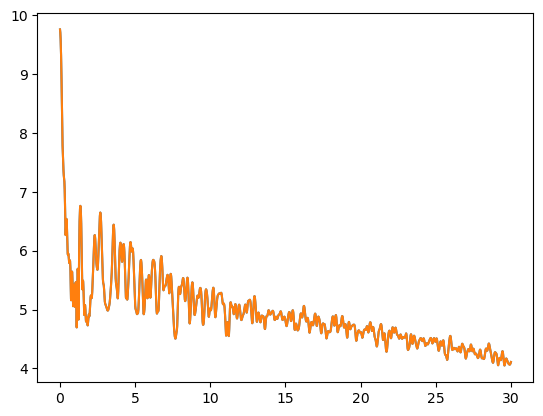

In [25]:
plt.plot(
    qIq_10x10x10_gpu_1[:,0],
    np.log10(qIq_10x10x10_gpu_1[:,1])
)
plt.plot(
    qIq_10x10x10_gpu_2[:,0],
    np.log10(qIq_10x10x10_gpu_2[:,1]),
)

In [ ]:
qIq, Fi = getQIq(scattering_factors_df=sf_df, atom_positions_path="GrSqf_cal_AP_Oct27/5IrC_r5a-1Ir.xyz", qmin=0.01, qmax=30, qstep=0.01, auto_save=False)

In [ ]:
plt.plot(qIq[:,0],np.log10(qIq[:,1]))

In [ ]:
qA = 1.0e-8
np.sin(qA)/qA

# Sq Calculation below
### Modified the above code to have sq also calculated at the same time as Iq

In [ ]:
def calculateSqData(atom_distance_matrix_df, qmin = 0.6, qmax =20 ,qstep =0.05 ):
    # atom_element looks like
    #   ['O', 'Co', 'O', 'O', 'O', 'O', 'O', 'Co', 'Co',...]
    atom_element = np.array([
        element_number.split('_')[0]
        for element_number
        in atom_distance_matrix_df.columns
    ])
    
    N = len(atom_element)

    # set(atom_element) looks like {'O', 'Co'}
    unique_elements = np.array(list(set(atom_element)))
    
    unique_elements_dict = {unique_elem:np.count_nonzero(atom_element == unique_elem) for unique_elem in unique_elements} 


    atom_distance_matrix = atom_distance_matrix_df.to_numpy()
    Iq_sum_list = []
    Fs_list = []
    Fs_sqr_list = []
    
    # loop on q rather than atom pairs
    q_range = np.arange(qmin, qmax, qstep)
    
    for  q in q_range:
        Fi = np.full_like(atom_element, fill_value=np.nan, dtype=np.float64)
        Fi_sq = np.full_like(unique_elements, fill_value=np.nan, dtype=np.float64)
        #print(f"Fi ; {Fi}" )
        
        for element in atom_element:
            #print(f"element = {element}")
            scattering_values = Scattering_Factors[element]
            fi1 = scattering_values[0]*np.exp(-scattering_values[1]*((q/(4*np.pi))**2))
            fi2 = scattering_values[2]*np.exp(-scattering_values[3]*((q/(4*np.pi))**2))
            fi3 = scattering_values[4]*np.exp(-scattering_values[5]*((q/(4*np.pi))**2)) 
            fi4 = scattering_values[6]*np.exp(-scattering_values[7]*((q/(4*np.pi))**2))
            fic = scattering_values[8]

            #print(f"unique_element == {element}")
            Fi[atom_element == element] = fi1 + fi2 + fi3 + fi4 + fic
            Fi_sq[unique_elements == element] = fi1 + fi2 + fi3 + fi4 + fic
        
        Fs_sqr_list.append(np.dot(np.square(Fi_sq),list(unique_elements_dict.values()))*(1/N))
        Fs_list.append(np.dot(Fi_sq,list(unique_elements_dict.values()))*(1/N))
        
        #sq_df = pd.DataFrame(Fi_sq_list, columns=unique_elements_dict.keys())
        
        
        
        Fi = Fi[np.newaxis, :]
        #print(np.shape(Fi))
        FiFj = Fi.T * Fi
        #print("FiFj")
        #print(FiFj)
        # the next line will cause a warning like this:
        #   ../site-packages/ipykernel_launcher.py:???: 
        #   RuntimeWarning: invalid value encountered in true_divide
        # but this is not an error, it tells us the sin_term_matrix has
        # NaN on the diagonal which will be corrected on the following line
        sin_term_matrix = np.sin(q*atom_distance_matrix) / (q*atom_distance_matrix)
        # set the diagonal elements to 1.0
        sin_term_matrix[np.diag_indices(sin_term_matrix.shape[0])] = 1.0
        #print("sin_term_matrix")
        #print(sin_term_matrix)

        Iq = FiFj * sin_term_matrix

        # sum Iq for each pair only once
        #Iq_sum_list.append(np.sum(Iq[np.triu_indices(Iq.shape[0])]))

        # sum Iq for each pair twice, except for "self" pairs such as (O_0, O_0)
        # (pairs from the diagonal of the distance matrix)
        Iq_sum_list.append(np.sum(Iq))
        
    #print(sq_data.head())
    #print("Iq.shape")
    #print(Iq.shape)
    
    sq = np.ones(q_range.shape) + (Iq_sum_list/(N*np.square(Fs_list))) - (Fs_sqr_list/np.square(Fs_list))
    fq = (sq - np.ones(q_range.shape))*q_range
    
    sq_dataframe = pd.DataFrame(np.column_stack([q_range,Iq_sum_list]),
                           columns= ['q', 'Iq'])
    sq_dataframe['Sq'] = sq
    sq_dataframe['Fq'] = fq
    
    qIq = np.column_stack((
        q_range,
        Iq_sum_list
    ))
    #print("qIq")
    #print(qIq)
    return sq_dataframe

def getSQIq(file = '28108-ICSDNi23_SolX.xyz', qmin = 0.6, qmax =30 ,qstep =0.02, auto_save = False):
    atom_positions, atom_positions_df = load_data(filename = file)
    
    atom_distance_matrix_df = create_atom_distance_matrix(atom_positions_df)
    #print("atom_distance_matrix_df", atom_distance_matrix_df.shape)
    #print(atom_distance_matrix_df[:10])

    sq_dataframe = calculateSqData(
        atom_distance_matrix_df,
        qmin=qmin, qmax=qmax, qstep=qstep
    )
    
    plt.plot(sq_dataframe['q'],sq_dataframe['Sq'])
    plt.plot(sq_dataframe['q'],sq_dataframe['Fq'])
    plt.xlabel('q')
    plt.ylabel('Sq')
    plt.title('q vs Sq')
    
    if auto_save:
        sq_dataframe.to_csv(file.split('.')[0]+'_Sq_Restuls.csv', index = False)
    return sq_dataframe


def getGr(q,fq,rmin=0,rmax= 100,rstep = 0.01,extrapolate_method = 'scipy'):

    #rmin and rmax are not for saved data
    #they are for rstep (x-axis) after IFFT, please see the min_x = int(np.ceil((rmin) / rstep))   
    #max_x = int(np.floor((rmax) / rstep)) + 1  
   
    qstep = q[1] - q[0]
    #print("beforecalfq =", len(fq))
    #print("qstep = ", qstep)

    datapoint = int (q[1]/qstep)
    #print("datapoint = ", datapoint)
    before_q = np.zeros(datapoint)  #calqx = before_q
    before_fq = np.zeros(datapoint)   #calfqx  = before_fq

    #linear extrapolation between 0 to starting q[0] from the loaded fq data.
    #For inverse fft, fq data point must be started at q=0 
    # if q start from 0, adding points from 0 to q[0] is not necessary
    # option1: linear extrapolation from 0 to fq[0]
    if q[0] > 0:
        if extrapolate_method == 'linear': #linear interpolation
            for x in range (datapoint):
                qi = x*qstep
                before_q[x] = qi
                before_fq[x] = fq[1]/q[1]*qi
        if extrapolate_method == 'scipy':  #linear extrapolation
            #extrapolation function
            f = interpolate.interp1d(q, fq, fill_value = "extrapolate")
            for x in range(datapoint):
                before_q[x] = x*qstep
                before_fq[x] = f(before_q[x])

    #calq, calfq를 위에서 만들어진 calqx, calfqx와 데이타를 합친다.
    #append calqx and calq and then save calqx, calfqx together
    q_final = np.append(before_q, q)
    fq_final = np.append(before_fq, fq)

    #making x-axis data set after IFFT
    #np.ceil does round at first decimal point. 0.5 --> 1, 0.4 --> 0
    #np.floor cuts decimal point and does not round 0.5--> 0, 1.5-->1
    #adding np.ceil and np.floor is safe to get xout. 
    #without np.ceil and np.floor, when rmin = 0.01 and rstep = 0.19,
    #lostep_nonpceil 0.05263157894736842, histep_nonpfloor 527.3157894736842
    #flooting number may cause issue at xout by arange function.
    #"+ 1" is required at histep because the last datapoint must be matched with the last datapoint at histep
    #"np.arange(min_x, max_x) * rstep" is for matching "step of xout data" with "rstep".
    min_x = int(np.ceil((rmin) / rstep))   
    max_x = int(np.floor((rmax) / rstep)) + 1  

    #make x-axis (real space, r(Angstrom)) data set after IFFT, step of x_axis si equla to rstep. 
    x_axis = np.arange(min_x, max_x) * rstep
    #print('x_axis = ', x_axis)

    #realationship between qmax (=qmaxrstep) vs. rstep --> rstep = np.pi/qmax.
    #refer to page 101 in "Underneath the bragg Peaks 2nd edition"
    qmaxrstep = np.pi / rstep

    #print('qmaxrstep = ', qmaxrstep)
    nin = len(q_final)
    #print('nin = ', nin)
    nbase = max(nin, max_x, qmaxrstep / qstep)
    #print('max_x = ', max_x)
    #print('qmaxrstep / qstep = ', qmaxrstep / qstep)
    #print('nbase =', nbase)
    ####==========================below ?????????????
    #nbaselog2 = np.log2(nbase)
    #print('nbaselog2 = ', nbaselog2)
    # refer https://github.com/diffpy/libdiffpy/blob/1bfd8f8ae9ec17d2cc0fdf32d6af5e75d10c3b9d/src/diffpy/srreal/PDFUtils.cpp#L45-L84%200

    nlog2 = int(np.ceil(np.log2(nbase)))
    #print('nlog2 = ', nlog2)
    nout = 2 ** nlog2
    #print('nout = ', nout)
    qmaxdb = 2 * nout * qstep
    #print('qmaxdb = ', qmaxdb)

    #####==========================above ????????????????

    yindb = np.concatenate((fq_final, np.zeros(2 * nout - nin)))
    #np.savetxt('yindb.txt', yindb) #what's this?
    print('yindb = ', yindb)
    #Gr calculation by inverse fft (IFFT)
    cyoutdb = np.fft.ifft(yindb) * 2 / np.pi * qmaxdb
    youtdb = np.imag(cyoutdb)
    xstepfine = 2 * np.pi / qmaxdb
    xoutfine = np.arange(nout) * xstepfine
    youtfine = youtdb[:nout]
    
    return xoutfine, youtfine

In [ ]:
%time qIq = getSQIq(file='5IrC_r5a-1Ir.xyz', qmin=0.01, qmax=30, qstep=0.01, auto_save=True)

In [ ]:
def getSQIqGr(file = '28108-ICSDNi23_SolX.xyz', qmin = 0.6, qmax =30 ,qstep =0.02,
              rmin=0,rmax= 100,rstep = 0.01, auto_save = False):
    
    atom_positions, atom_positions_df = load_data(filename = file)
    
    atom_distance_matrix_df = create_atom_distance_matrix(atom_positions_df)
    #print("atom_distance_matrix_df", atom_distance_matrix_df.shape)
    #print(atom_distance_matrix_df[:10])

    SqIqGr_dataframe = calculateSqData(
        atom_distance_matrix_df,
        qmin=qmin, qmax=qmax, qstep=qstep
    )
    
    r, gr = getGr(SqIqGr_dataframe['q'],SqIqGr_dataframe['Fq'],rmin=rmin,rmax= rmax,rstep = rstep,
                  extrapolate_method = 'linear')  #'linear' or 'scipy'
    
    print(f" r length ={len(r)}, pd series ;  {len(pd.Series(r))}")
    print(f" r last ={r[-1]}")
    print(f"q length ={len(SqIqGr_dataframe['q'])}")
    
    Gr_dataframe = pd.DataFrame(columns=['r', 'Gr'])
    
    Gr_dataframe['r'] = pd.Series(r)
    Gr_dataframe['Gr'] = pd.Series(gr)
          
    
    SqIqGr_dataframe = pd.concat([Gr_dataframe, SqIqGr_dataframe], axis=1)
          
    fig, (ax1, ax2) = plt.subplots(2, 1)
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)
    

    ax1.plot(SqIqGr_dataframe['q'],SqIqGr_dataframe['Sq'], label = 'S(q)')
    ax1.plot(SqIqGr_dataframe['q'],SqIqGr_dataframe['Fq'], label = 'F(q)')
    ax1.set_xlabel('q')
    ax1.set_ylabel('Sq')
    ax1.set_title('q vs Sq vs Fq')
    ax1.legend()
    
    ax2.plot(SqIqGr_dataframe['r'],SqIqGr_dataframe['Gr'], 'r')
    ax2.set_xlabel('r')
    ax2.set_ylabel('Gr')
    ax2.set_title('r vs Gr')
    plt.xlim(rmin, rmax)
    
    if auto_save:
        SqIqGr_dataframe.to_csv(file.split('.')[0]+'_IqSqGr_Restuls.csv', index = False)
    return SqIqGr_dataframe

In [ ]:
df = getSQIqGr(file = '5IrC_r5a-1Ir.xyz', qmin = 0.01, qmax =30, qstep =0.01, 
               rmin=0, rmax= 15, rstep = 0.01, auto_save = True)